# MASTER - Notebook 2
### Matteo Grazioso 884055

In [47]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import json



import warnings
warnings.filterwarnings('ignore')

# Create a requirements.txt file
!pip freeze > requirements.txt


In [48]:
# Disply all columns and all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [49]:
# The data is in the same directory as the notebook and is named 'df_new.txt'
# The file contains the data of the validation of tickets in the city of public transport of Venice.
# The file has been created by the Notebook 1.ipynb

# Import the data into a dataframe of a txt file
df = pd.read_csv('data/processed/dataset_cleaned.txt', header=0, sep='\t')

# Display the first 5 rows of the dataframe
df.head()

df['DATA'] = pd.to_datetime(df['DATA'], format='%Y-%m-%d')


---------


## Focus on specific types of tickets

In [50]:
from datetime import datetime

def to_datetime(date):
    """
    Converts a numpy datetime64 object to a python datetime object 
    Input:
      date - a np.datetime64 object
    Output:
      DATE - a python datetime object
    """
    # timestamp = ((date - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's'))
    # return datetime.utcfromtimestamp(timestamp)
    #date = pd.to_datetime(date)
    date = datetime.strptime(date, '%Y-%m-%d')
    return date

# Credits: Brian Blaylock in GitHub Gist https://gist.github.com/blaylockbk/1677b446bc741ee2db3e943ab7e4cabd 

def to_pd_datetime(date):
    """
    Converts a string to a pandas datetime object in the format '%Y-%m-%d'
    Input:
      date - a string
    Output:
      date - a pandas datetime object
    """
    date = pd.to_datetime(date, format='%Y-%m-%d')
    return date

In [51]:
def get_ticket_code_description(ticket_code):
    """
    Given the key of the ticket code, return the description of the ticket code contained in the dictionary dict_ticket_code.json
    Input:
      ticket_code - a string that is the key of the dictionary
    Output:
      description - a string that is the description of the ticket code, value of the dictionary
    """
    with open('data/dictionaries/dict_ticket_codes.json') as f:
        data = json.load(f)
    description = data[ticket_code]
    return description

In [52]:
# Focus on TICKET_CODE and TICKET_TYPE
def focus_on_ticket_code(df_tc, ticket_code):
    """
        This function returns a dataframe with only the rows of the specified ticket code.
        :param df: the dataframe
        :param ticket_code: the ticket code
        :return: the dataframe with only the rows of the specified ticket code
    """
    # Select only the rows of the specified ticket code
    df_tc = df_tc[df_tc['TICKET_CODE'] == ticket_code]
    df_tc.head()
    return df_tc

# Focus on TICKET_TYPE
def focus_on_ticket_type(df_tt, ticket_type):
    """
        This function returns a dataframe with only the rows of the specified ticket type.
        :param df: the dataframe
        :param ticket_type: the ticket type
        :return: the dataframe with only the rows of the specified ticket type
    """
    # Select only the rows of the specified ticket type
    df_tt = df_tt[df['DESCRIZIONE_TITOLO'] == ticket_type]
    df_tt.head()
    return df_tt

# Functions to focus on a specific ticket code or ticket type
def number_of_tickets_per_day(df_d, target_ticket_code_or_type, is_ticket_code):
    """
        This function plots the number of validations of the specified ticket code for each day.
        :param df: the dataframe
        :param target_ticket_code: the ticket code
        :param is_ticket_code: a boolean that specifies if the target is a ticket code or a ticket type
        :return: None
    """
    # Group the dataframe by date and hour and count the number of validations of the specified ticket code
    df_d = df_d.groupby('DATA').count()['SERIALE'].reset_index()    
    df_d['cumulative_sum'] = df_d.groupby('DATA')['SERIALE'].cumsum()
    
    # Plot the cumulative sum of the number of validations of the target ticket code or type for each day
    plt.figure(figsize=(20, 10))
    plt.plot(df_d['DATA'], df_d['cumulative_sum'])

    if is_ticket_code:
        descr = get_ticket_code_description(target_ticket_code_or_type)
        plt.title('Cumulative sum of the number of validations of the ticket code "{}" - "{}" for each day'.format(target_ticket_code_or_type, descr), fontsize=20)
    else:
        plt.title('Cumulative sum of the number of validations of the ticket type "{}" for each day'.format(target_ticket_code_or_type), fontsize=20)
    plt.xlabel('Date - days', fontsize=15)
    plt.ylabel('Cumulative sum', fontsize=15)

    # Calculate the step of the y-axis
    step = int(df_d['cumulative_sum'].max()/10)
    # Manage the y-axis
    plt.yticks(ticks=np.arange(0, df_d['cumulative_sum'].max()+step, step))

    # Manage the x-axis: rotate the labels of the x-axis
    plt.xticks(rotation=45)

    plt.show()

def min_max_number_of_tickets_per_day(df_d, target_ticket_code_or_type, is_ticket_code):
    """
        This function prints the day with the highest and the day with the lowest number of validations of the specified ticket code or ticket type.
        :param df: the dataframe
        :param target_ticket_code_or_type: the ticket code or ticket type
        :param is_ticket_code: a boolean that specifies if the target is a ticket code or a ticket type
        :return: None
    """
    # Group the dataframe by date and hour and count the number of validations of the specified ticket code
    df_d = df_d.groupby('DATA').count()['SERIALE'].reset_index()
    max = df_d[df_d['SERIALE'] == df_d['SERIALE'].max()]
    min = df_d[df_d['SERIALE'] == df_d['SERIALE'].min()]

    # Composing the string to print the result, specifying: 
    # - if the target is a ticket code or a ticket type,
    # - converting the date to string format '%Y-%m-%d' and
    # - if is a ticket code, getting the description of the ticket code
    if is_ticket_code:
        # Get the description of the ticket code
        descr = ' - "' + get_ticket_code_description(target_ticket_code_or_type) + '"'
    else:
        descr = ''
    
    s = 'The {} number of validations of the {} "{}"' + descr + ' was {} with {} validations'
    for i in range(0, 2):
        if i == 0:
            if is_ticket_code:
                print(s.format('highest', 'ticket code', target_ticket_code_or_type, max['DATA'].values[0].astype('datetime64[D]').astype(str), max['SERIALE'].values[0]))
            else:
                print(s.format('highest', 'ticket type', target_ticket_code_or_type, max['DATA'].values[0].astype('datetime64[D]').astype(str), max['SERIALE'].values[0]))
        else:
            if is_ticket_code:
                print(s.format('lowest', 'ticket code', target_ticket_code_or_type, min['DATA'].values[0].astype('datetime64[D]').astype(str), min['SERIALE'].values[0]))
            else:
                print(s.format('lowest', 'ticket type', target_ticket_code_or_type, min['DATA'].values[0].astype('datetime64[D]').astype(str), min['SERIALE'].values[0]))


def barplot_number_of_tickets_per_month(df_m, target_ticket_code_or_type, is_ticket_code):
    """
        This function plots the number of validations of the specified ticket code or ticket type for each month.
        :param df: the dataframe
        :param target_ticket_code_or_type: the ticket code or ticket type
        :param is_ticket_code: a boolean that specifies if the target is a ticket code or a ticket type
        :return: None
    """
    # Create a dataframe with the number of validations of the target ticket for each month
    # The column 'DATA' is in pd.datetime format as '%d/%m/%Y'
    # Convert the column 'DATA' to pd.datetime format as '%Y/%m' using astype('datetime64[M]').astype(str)
    # Group the dataframe by the column 'DATA' and count the number of validations of the target ticket

    # Set all the values of the date on the first day of the month
    df_m['DATA'] = df_m['DATA'].dt.strftime('%Y-%m-01')
    #df_m['DATA'] = df_m['DATA'].apply(lambda x: pd.Timestamp(x))


    df_m = df_m.groupby('DATA').count()['SERIALE'].reset_index(drop=False)

    df_m['DATA'] = df_m['DATA'].astype('datetime64[M]').astype(str)

    # Remove the last 3 characters of the date (the day) to have the date in the format '%Y/%m' 
    for i in range(0, len(df_m['DATA'])):
        df_m['DATA'][i] = df_m['DATA'][i][:-3]
    
    # Plot the cumulative sum of the number of validations of the target ticket code or type for each month
    plt.figure(figsize=(20, 10))
    plt.bar(df_m['DATA'], df_m['SERIALE'])

    if is_ticket_code:
        descr = get_ticket_code_description(target_ticket_code_or_type)
        plt.title('Cumulative sum of the number of validations of the ticket code "{}" - "{}" for each month'.format(target_ticket_code_or_type, descr), fontsize=20)
    else:
        plt.title('Cumulative sum of the number of validations of the ticket type "{}" for each month'.format(target_ticket_code_or_type), fontsize=20)
    plt.xlabel('Date - months', fontsize=15)
    plt.ylabel('Cumulative sum', fontsize=15)

    # Calculate the step of the y-axis
    step = int(df_m['SERIALE'].max()/10)
    # Manage the y-axis
    plt.yticks(ticks=np.arange(0, df_m['SERIALE'].max()+step, step))

    # Manage the x-axis: rotate the labels of the x-axis
    # Print the x-axis labels as '%Y/%m', so remove the day from the date and print only the year and the month of the date removing the last 3 characters
    # for i in range(0, len(df_m['DATA'])):
        #df_m['DATA'][i] = df_m['DATA'][i][:-3]
    
    plt.xticks(rotation=45, ticks=df_m['DATA'])

    plt.show()    

def min_max_number_of_tickets_per_month(df_m, target_ticket_code_or_type, is_ticket_code):
    """
        This function prints the month with the highest and the month with the lowest number of validations of the specified ticket code or ticket type.
        :param df: the dataframe
        :param target_ticket_code_or_type: the ticket code or ticket type
        :param is_ticket_code: a boolean that specifies if the target is a ticket code or a ticket type
        :return: None
    """
    # Convert DATA to datetime 
    df_m['DATA'] = pd.to_datetime(df_m['DATA'], format='%Y/%m/%d')
    # Set all the values of the date on the first day of the month
    df_m['DATA'] = df_m['DATA'].dt.strftime('%Y-%m-01')   
    
    # Group the dataframe by date and hour and count the number of validations of the specified ticket code
    df_m = df_m.groupby('DATA').count()['SERIALE'].reset_index()
        
    max = df_m[df_m['SERIALE'] == df_m['SERIALE'].max()]
    min = df_m[df_m['SERIALE'] == df_m['SERIALE'].min()]

    # Composing the string to print the result, specifying: 
    # - if the target is a ticket code or a ticket type,
    # - converting the date to string format '%Y-%m-%d' and
    # - if is a ticket code, getting the description of the ticket code
    if is_ticket_code:
        # Get the description of the ticket code
        descr = ' - "' + get_ticket_code_description(target_ticket_code_or_type) + '"'
    else:
        descr = ''
    
    s = 'The {} number of validations of the {} "{}"' + descr + ' was the month {} with {} validations.'
    for i in range(0, 2):
        if i == 0:
            if is_ticket_code:
                print(s.format('highest', 'ticket code', target_ticket_code_or_type, max['DATA'].values[0][:-3], max['SERIALE'].values[0]))
            else:
                print(s.format('highest', 'ticket type', target_ticket_code_or_type, max['DATA'].values[0][:-3], max['SERIALE'].values[0]))
        else:
            if is_ticket_code:
                print(s.format('lowest', 'ticket code', target_ticket_code_or_type, min['DATA'].values[0][:-3], min['SERIALE'].values[0]))
            else:
                print(s.format('lowest', 'ticket type', target_ticket_code_or_type, min['DATA'].values[0][:-3], min['SERIALE'].values[0]))

In [53]:
# Focus on all TICKET_CODEs
def focus_on_all_ticket_codes(df_tca, dictionary):
    """
        This function focuses on the different ticket codes.
        :param df_tca: the dataframe
        :param dictionary: the dictionary with the ticket codes and their description
        :return: None
    """
    # Open the dictionary
    import json
    with open(dictionary) as json_file: 
        dict_ticket_code = json.load(json_file)

    for ticket_code in dict_ticket_code.keys():
        # Select only the rows of the specified ticket code
        df_tca_sup = df_tca[df_tca['TICKET_CODE'] == ticket_code]
        # If the dataframe is empty, skip the ticket code but launch a warning
        if df_tca_sup.shape[0] == 0:
            print('WARNING: There are no validations of the ticket code "{}"'.format(ticket_code))
        else:
            # If the dataframe is not empty, focus on the ticket code
            df_tc = focus_on_ticket_code(df_tca_sup, ticket_code)
            number_of_tickets_per_day(df_tc, ticket_code, is_ticket_code=True)
            min_max_number_of_tickets_per_day(df_tc, ticket_code, is_ticket_code=True)
            barplot_number_of_tickets_per_month(df_tc, ticket_code, is_ticket_code=True)
            min_max_number_of_tickets_per_month(df_tc, ticket_code, is_ticket_code=True)

### Focus on the type of ticket named ***abbonamento 30 gg.PeopleMover***
The ticket is valid for 30 days and allows you to use the PeopleMover service

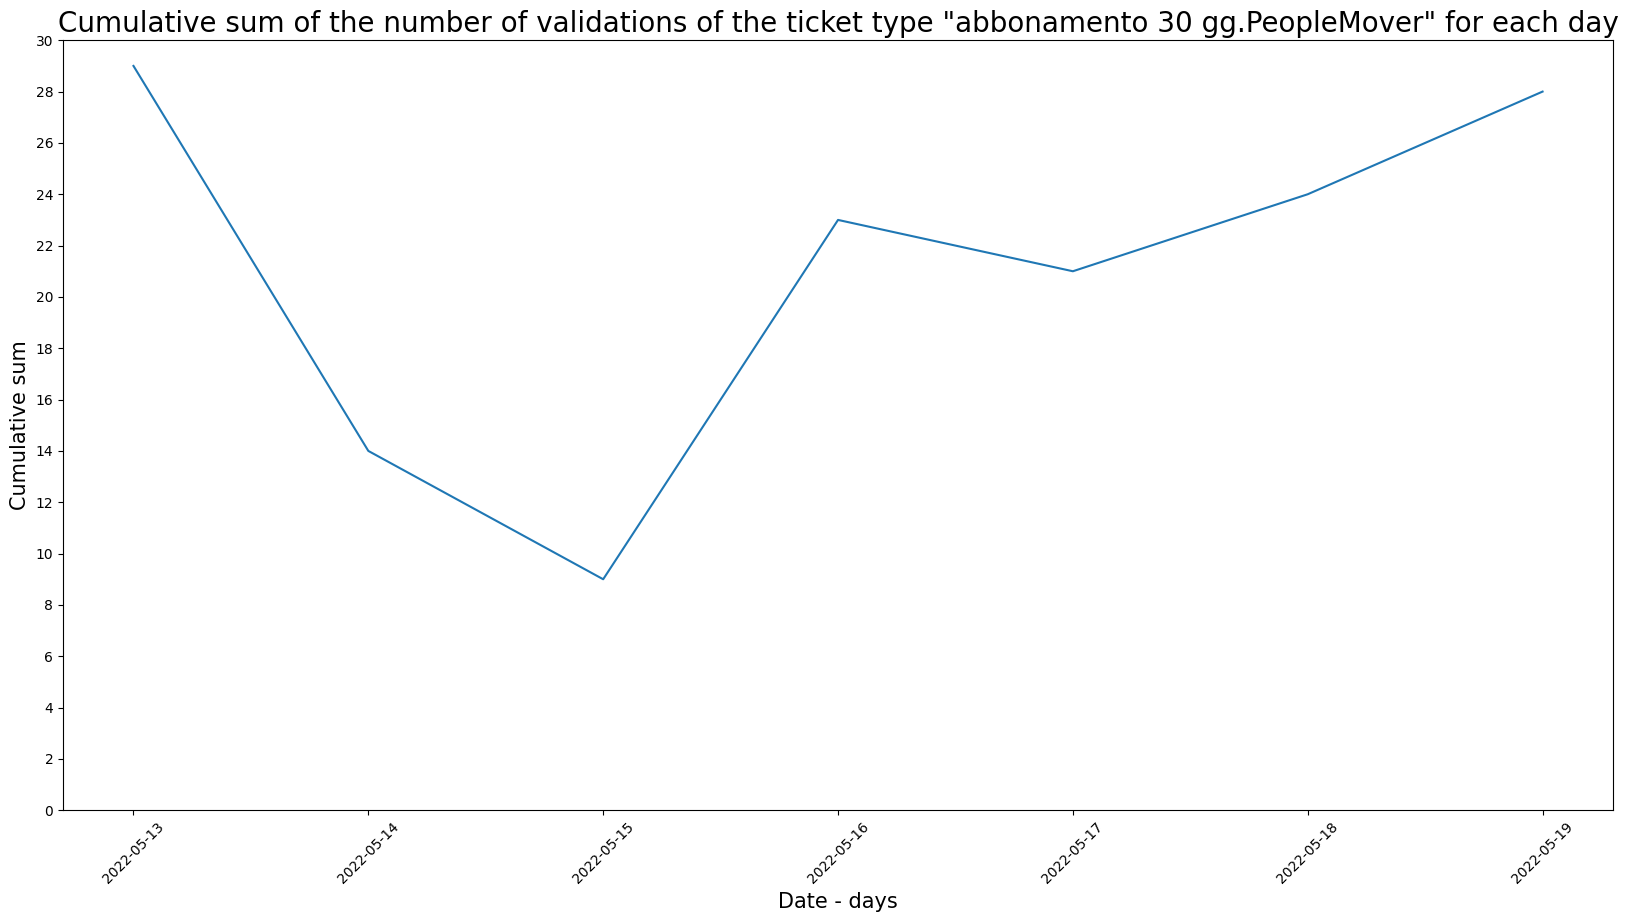

The highest number of validations of the ticket type "abbonamento 30 gg.PeopleMover" was 2022-05-13 with 29 validations
The lowest number of validations of the ticket type "abbonamento 30 gg.PeopleMover" was 2022-05-15 with 9 validations


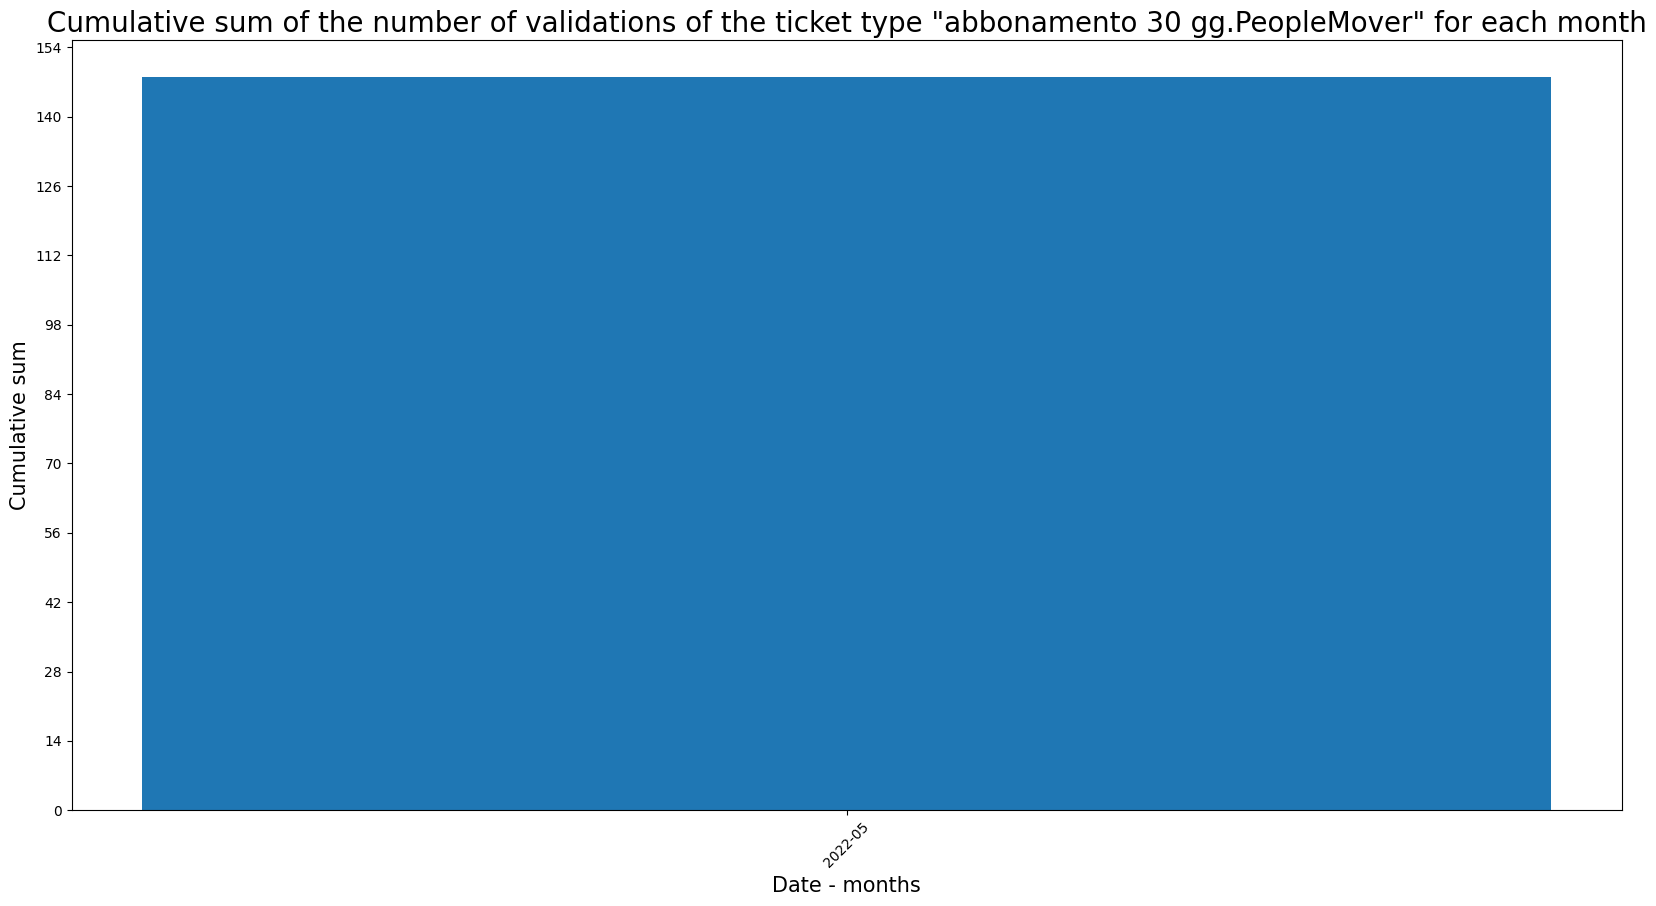

The highest number of validations of the ticket type "abbonamento 30 gg.PeopleMover" was the month 2022-05 with 148 validations.
The lowest number of validations of the ticket type "abbonamento 30 gg.PeopleMover" was the month 2022-05 with 148 validations.


In [54]:
target_ticket = 'abbonamento 30 gg.PeopleMover'
df_PM = focus_on_ticket_type(df, target_ticket)
number_of_tickets_per_day(df_PM, target_ticket, is_ticket_code=False)
min_max_number_of_tickets_per_day(df_PM, target_ticket, is_ticket_code=False)
barplot_number_of_tickets_per_month(df_PM, target_ticket, is_ticket_code=False)
min_max_number_of_tickets_per_month(df_PM, target_ticket, is_ticket_code=False)

### Focus on the ticket codes


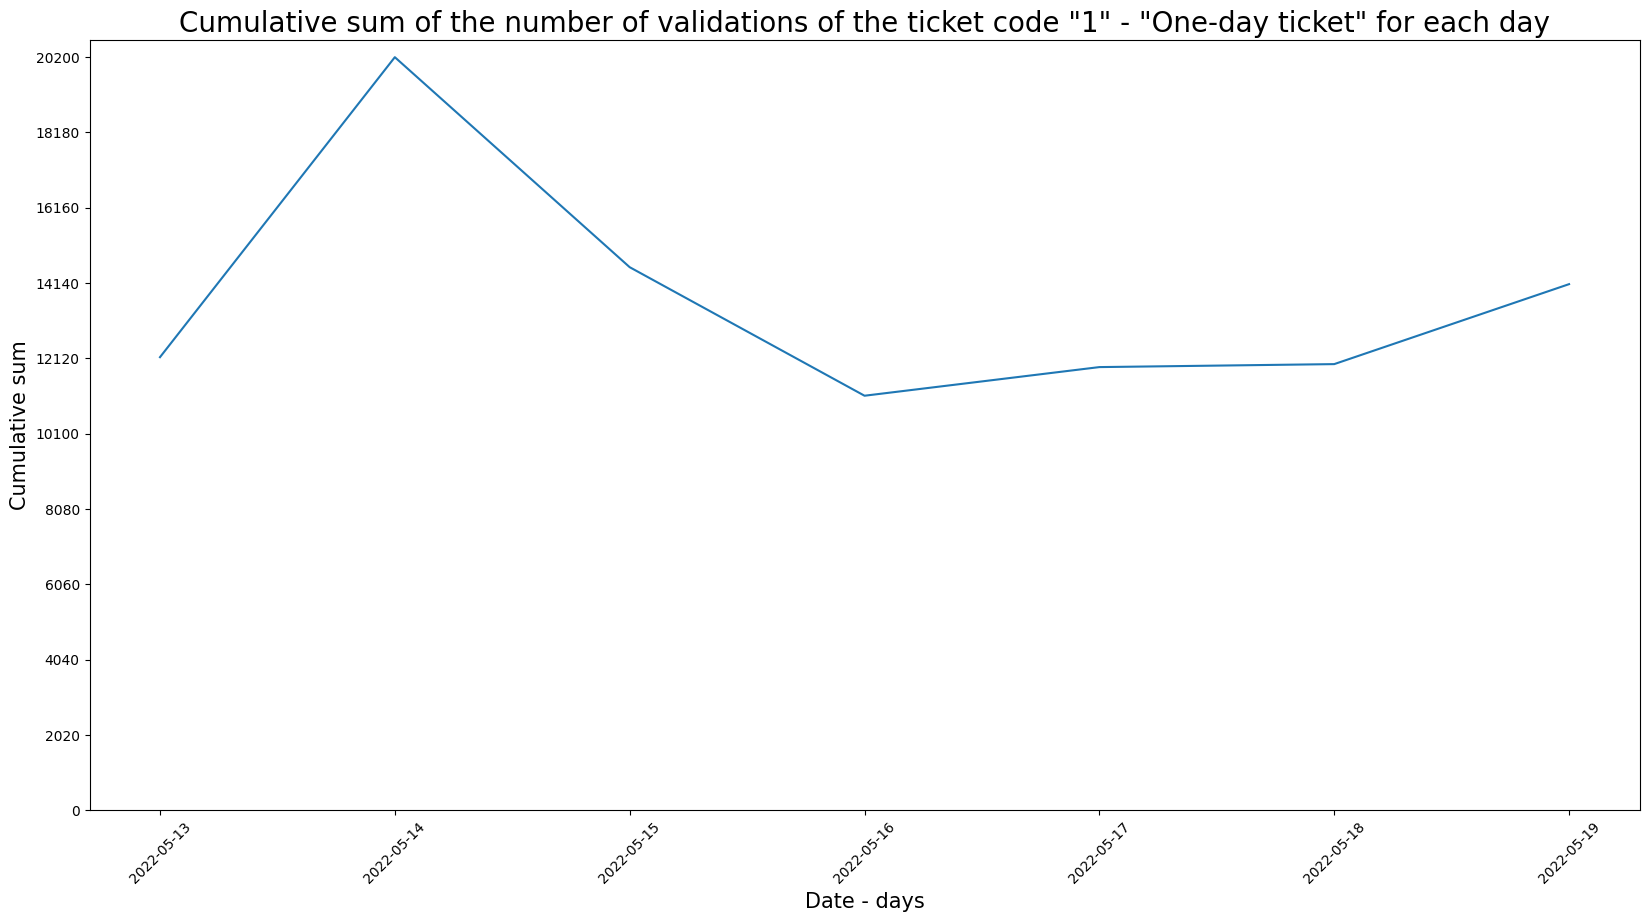

The highest number of validations of the ticket code "1" - "One-day ticket" was 2022-05-14 with 20200 validations
The lowest number of validations of the ticket code "1" - "One-day ticket" was 2022-05-16 with 11119 validations


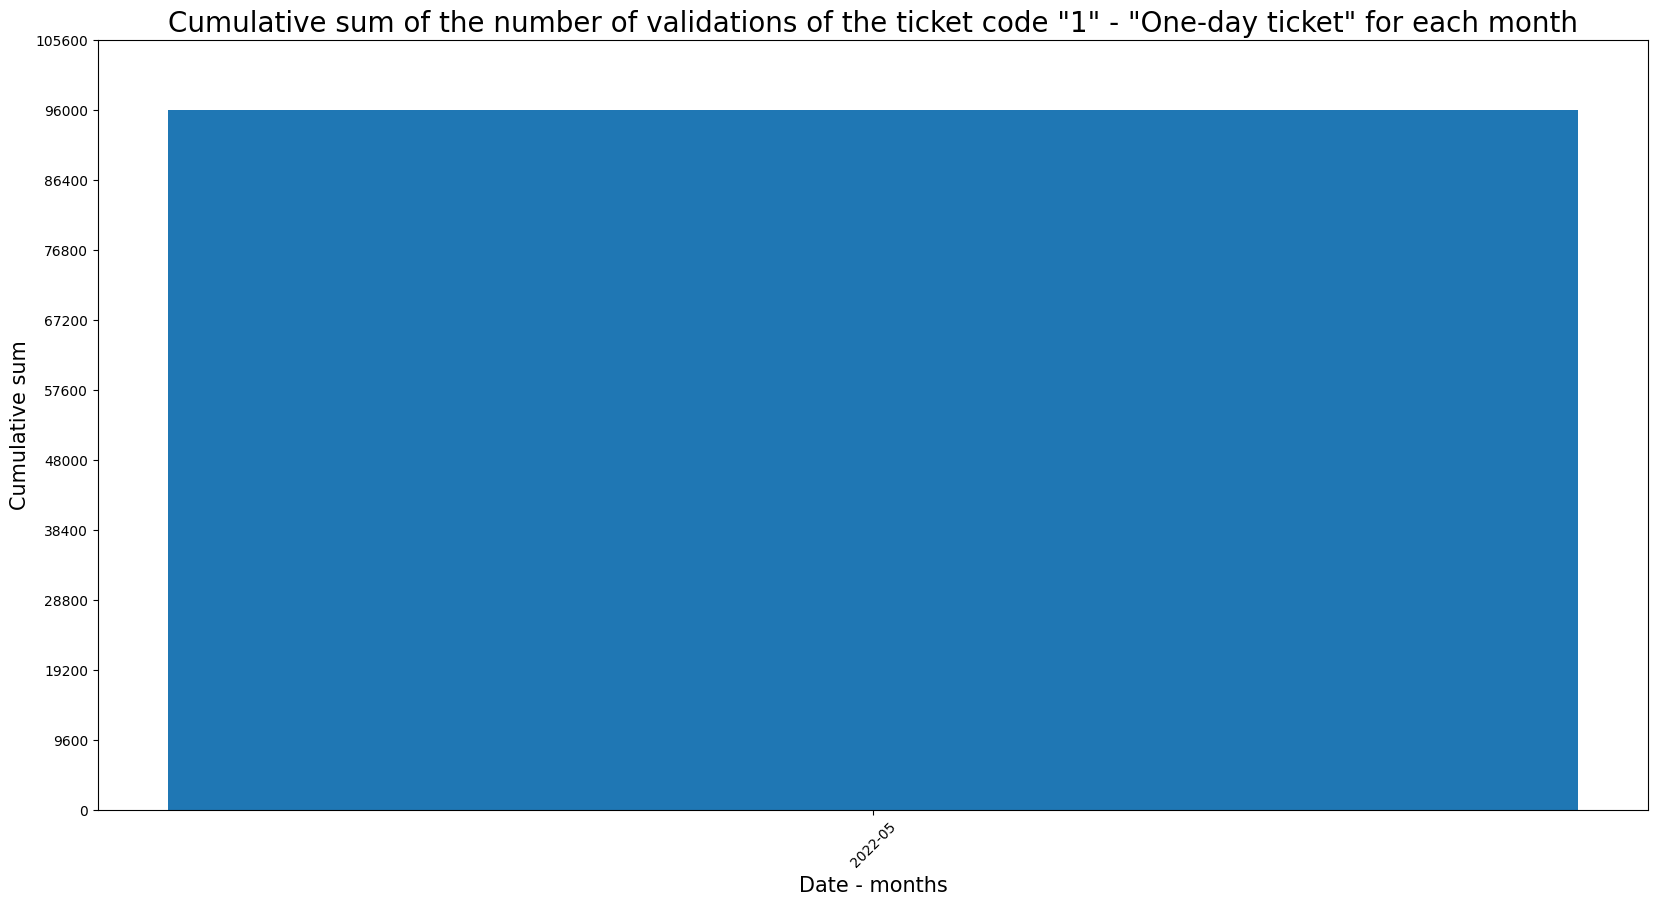

The highest number of validations of the ticket code "1" - "One-day ticket" was the month 2022-05 with 96005 validations.
The lowest number of validations of the ticket code "1" - "One-day ticket" was the month 2022-05 with 96005 validations.


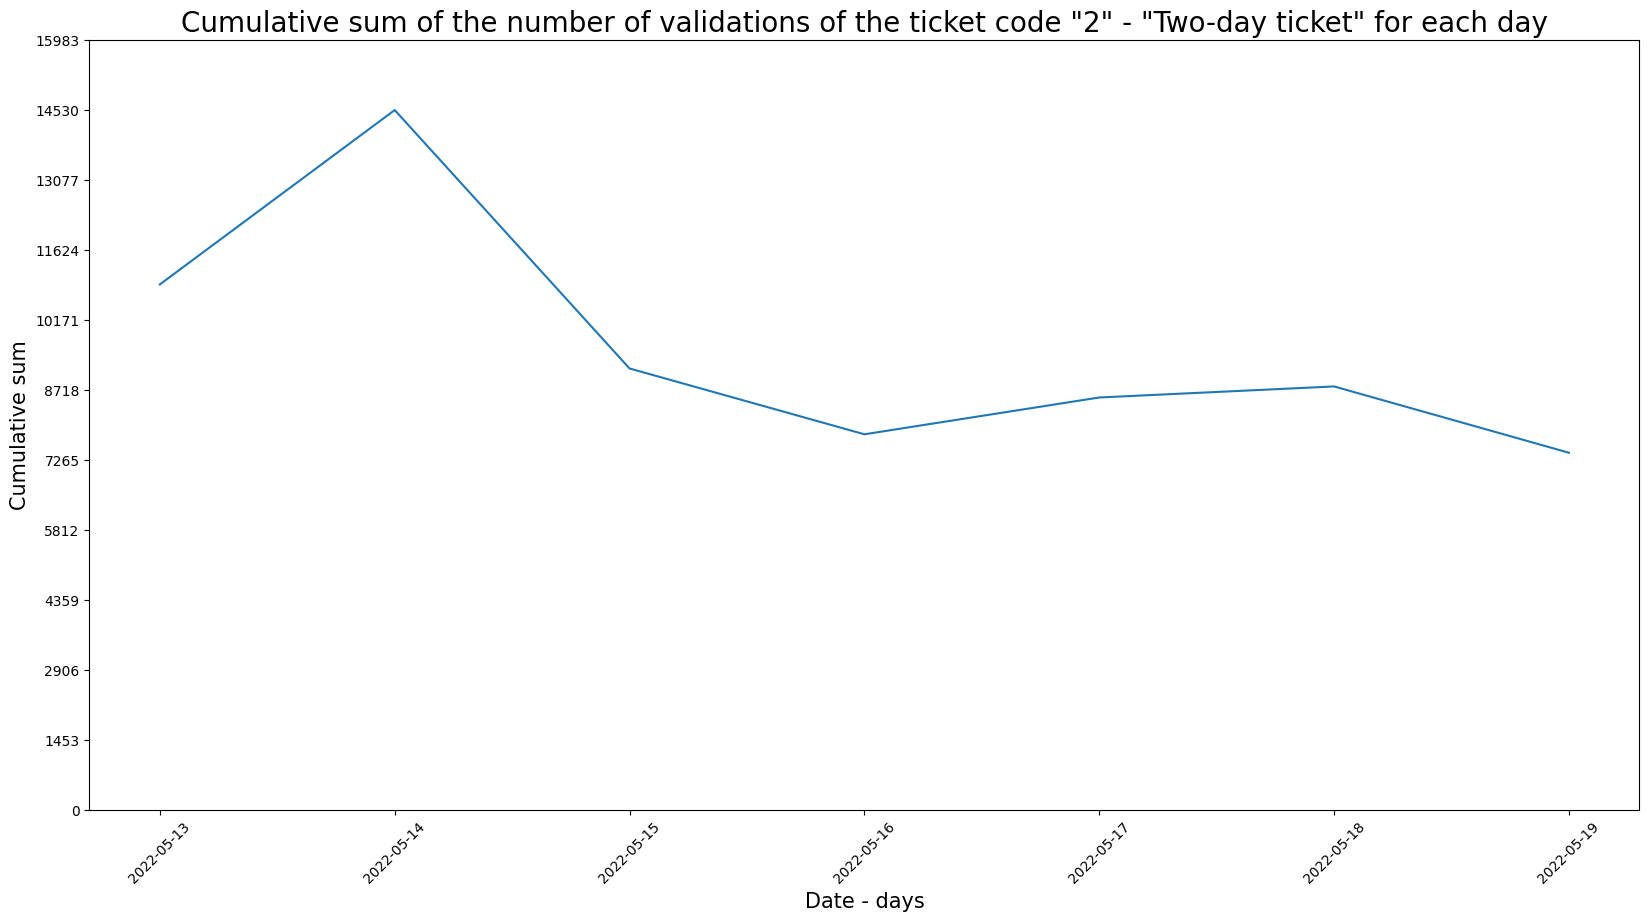

The highest number of validations of the ticket code "2" - "Two-day ticket" was 2022-05-14 with 14534 validations
The lowest number of validations of the ticket code "2" - "Two-day ticket" was 2022-05-19 with 7421 validations


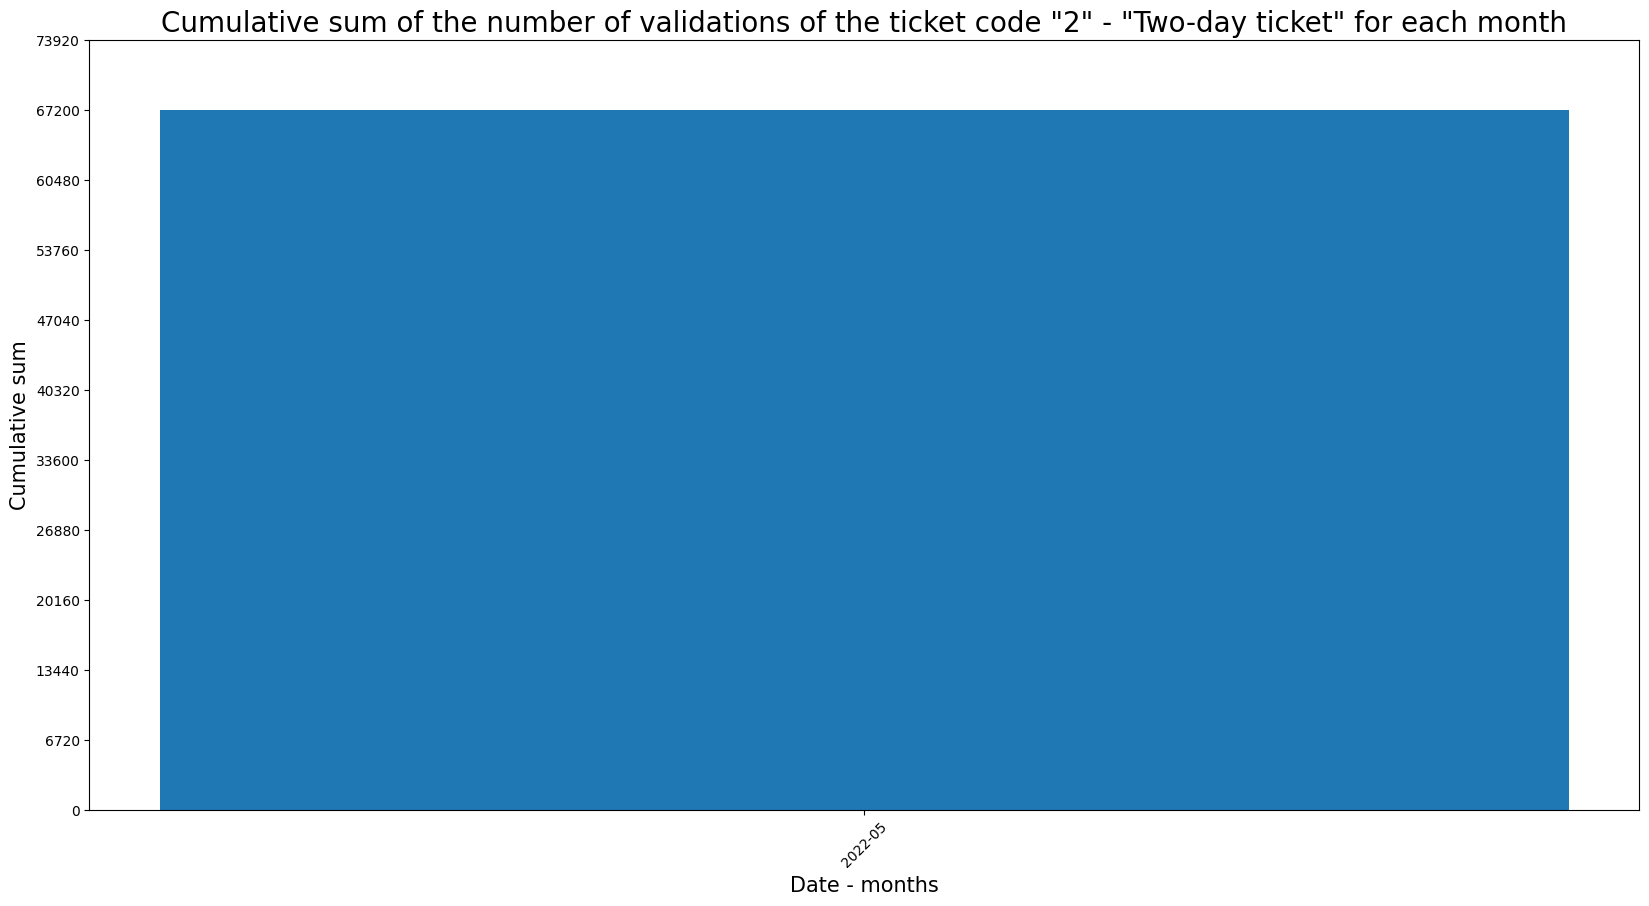

The highest number of validations of the ticket code "2" - "Two-day ticket" was the month 2022-05 with 67209 validations.
The lowest number of validations of the ticket code "2" - "Two-day ticket" was the month 2022-05 with 67209 validations.


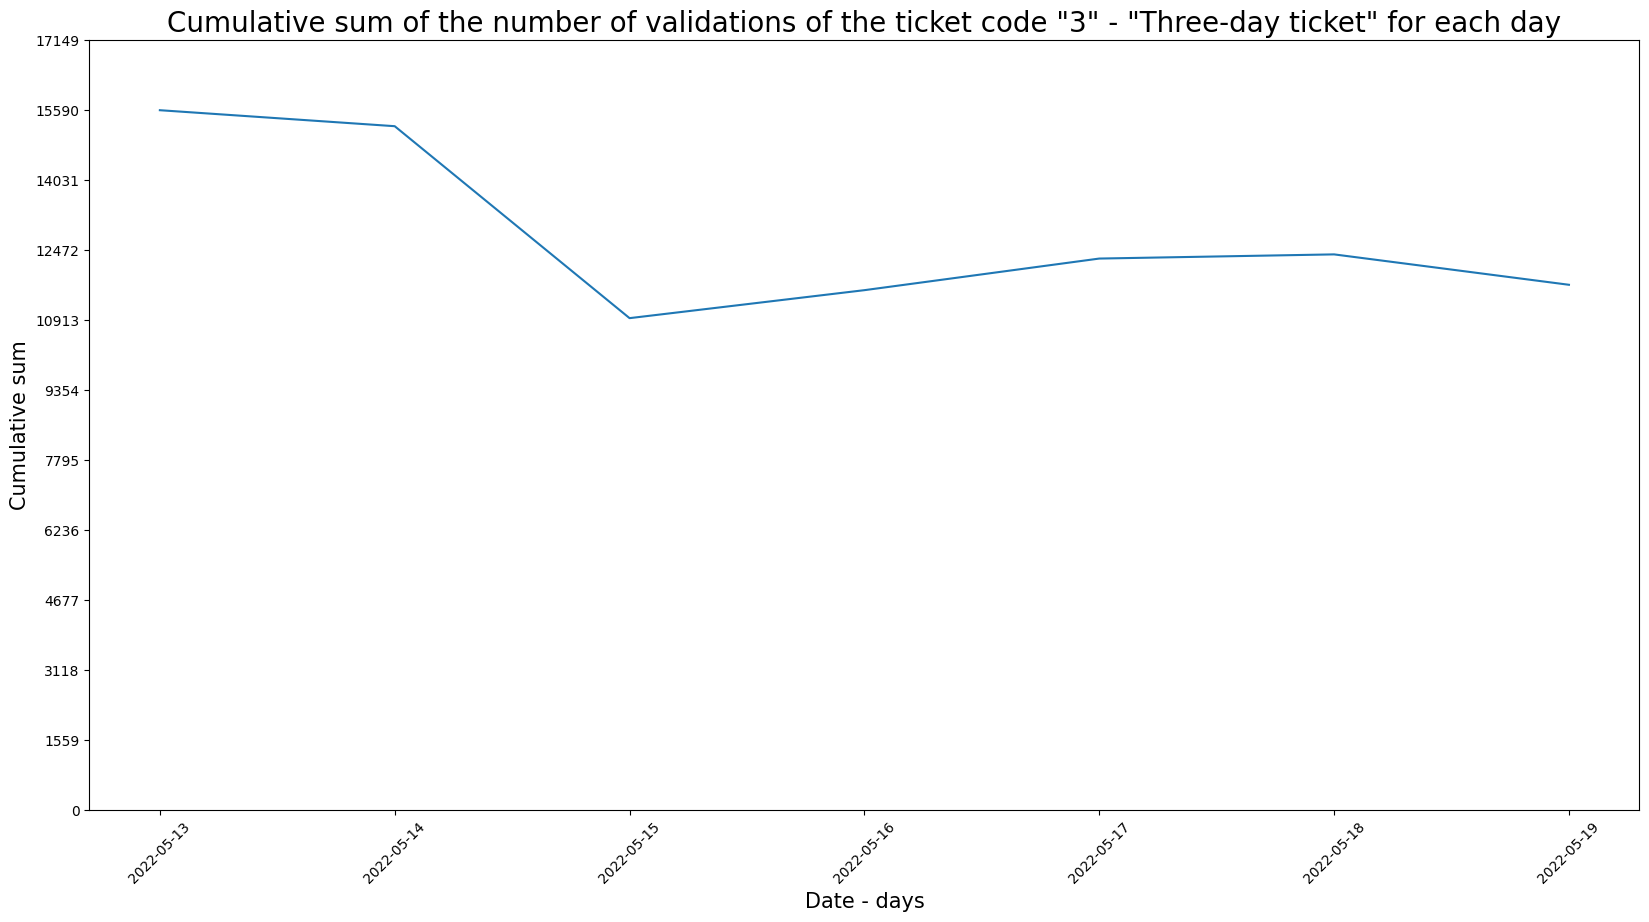

The highest number of validations of the ticket code "3" - "Three-day ticket" was 2022-05-13 with 15591 validations
The lowest number of validations of the ticket code "3" - "Three-day ticket" was 2022-05-15 with 10960 validations


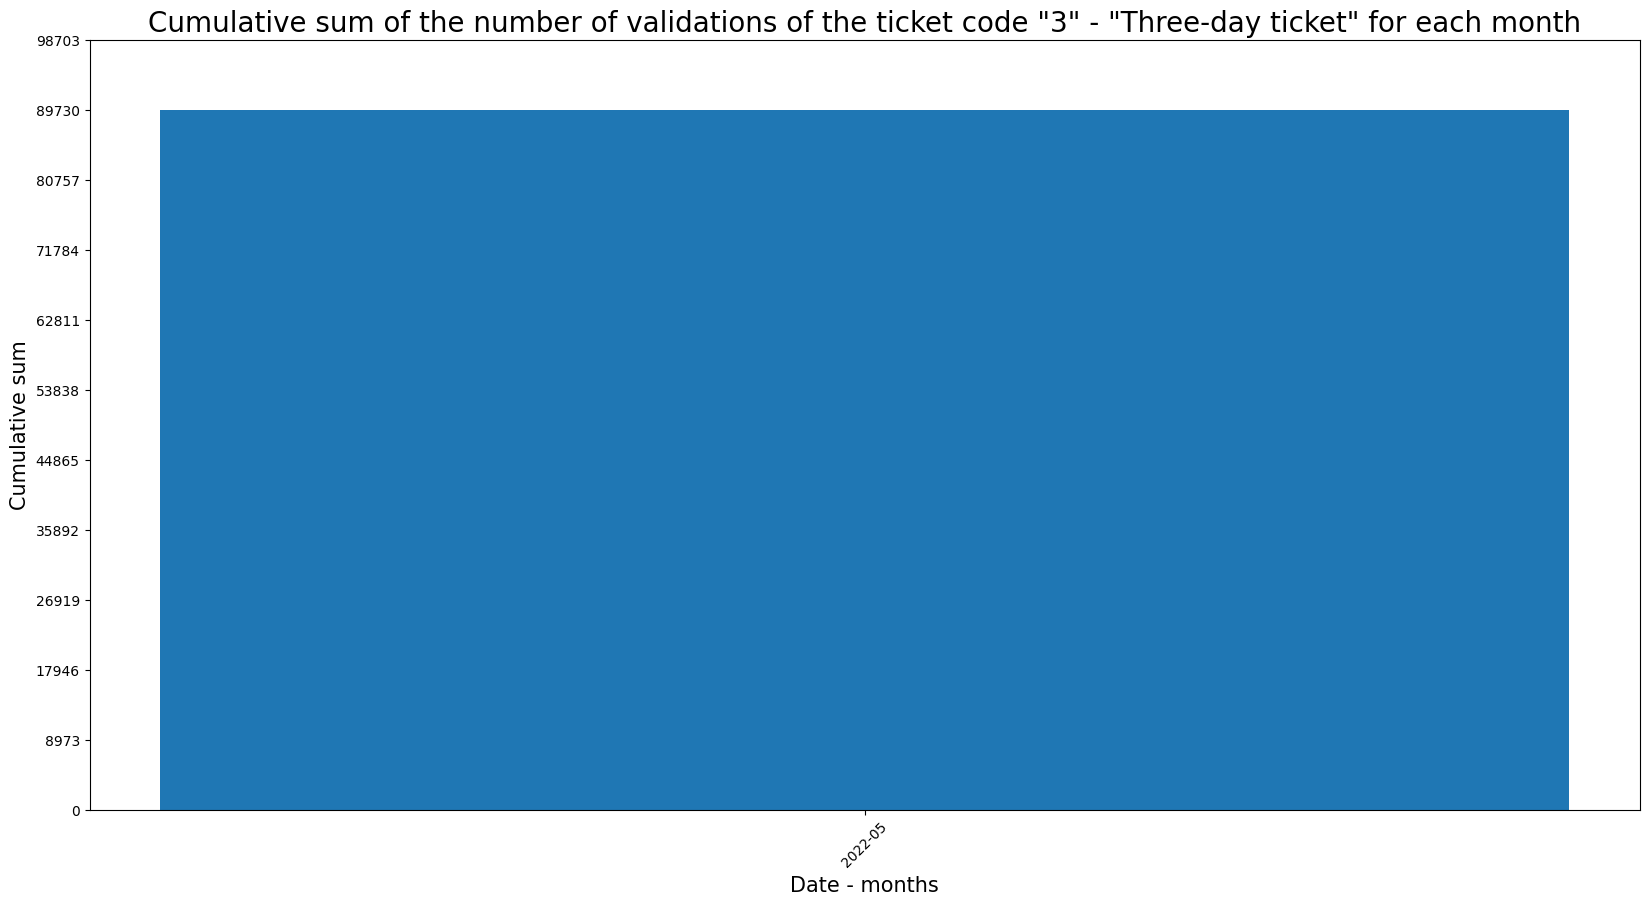

The highest number of validations of the ticket code "3" - "Three-day ticket" was the month 2022-05 with 89739 validations.
The lowest number of validations of the ticket code "3" - "Three-day ticket" was the month 2022-05 with 89739 validations.


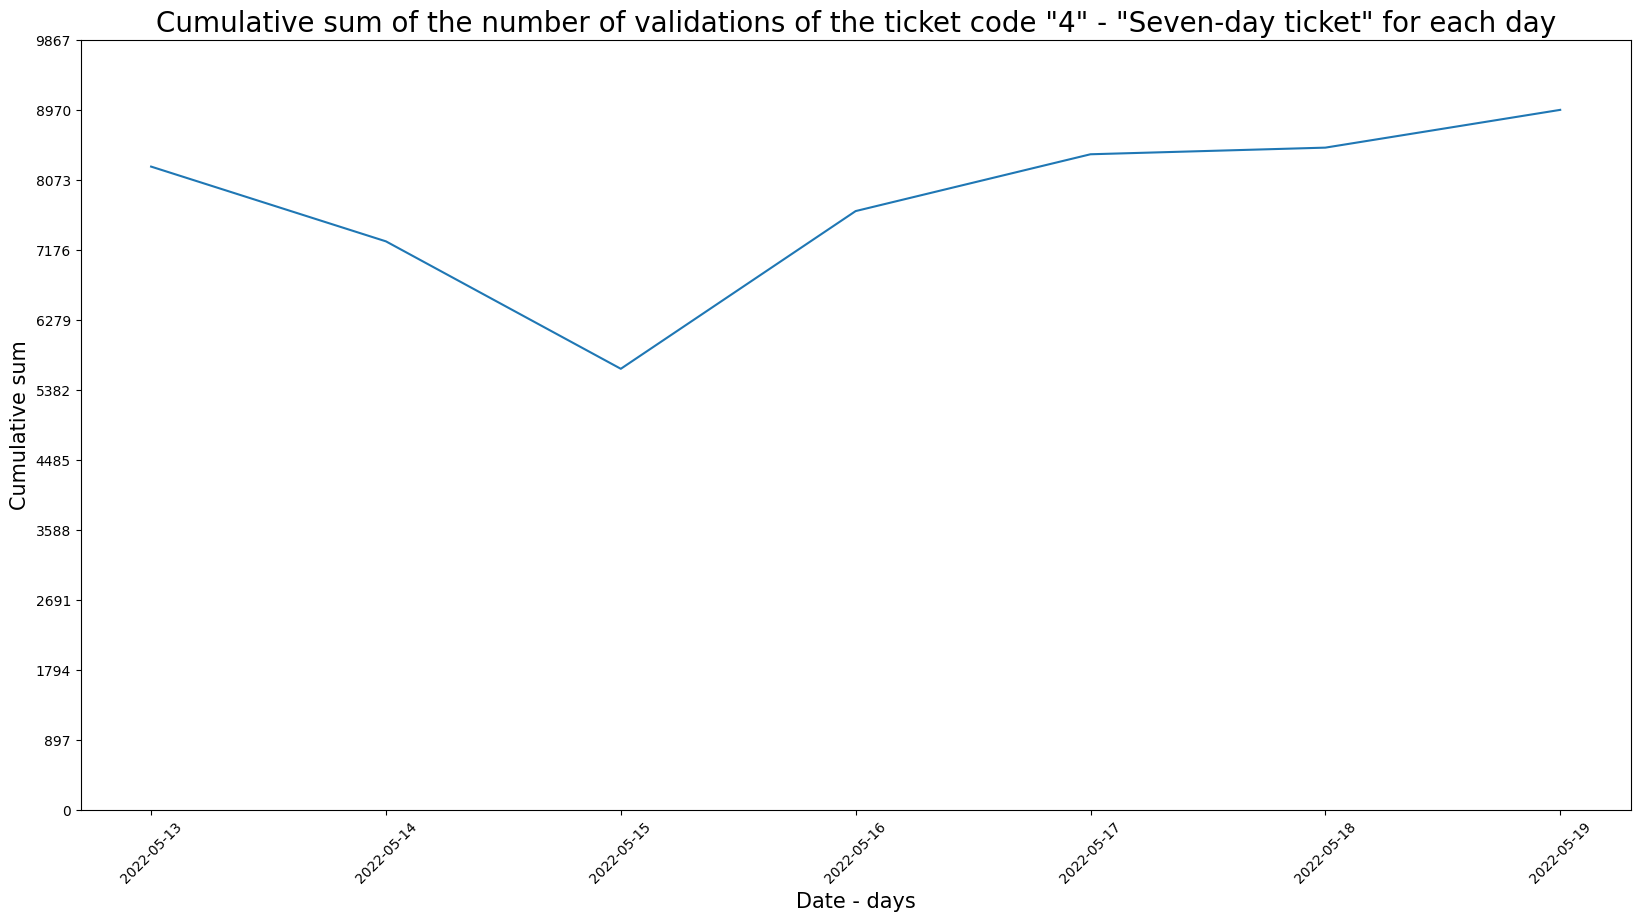

The highest number of validations of the ticket code "4" - "Seven-day ticket" was 2022-05-19 with 8975 validations
The lowest number of validations of the ticket code "4" - "Seven-day ticket" was 2022-05-15 with 5657 validations


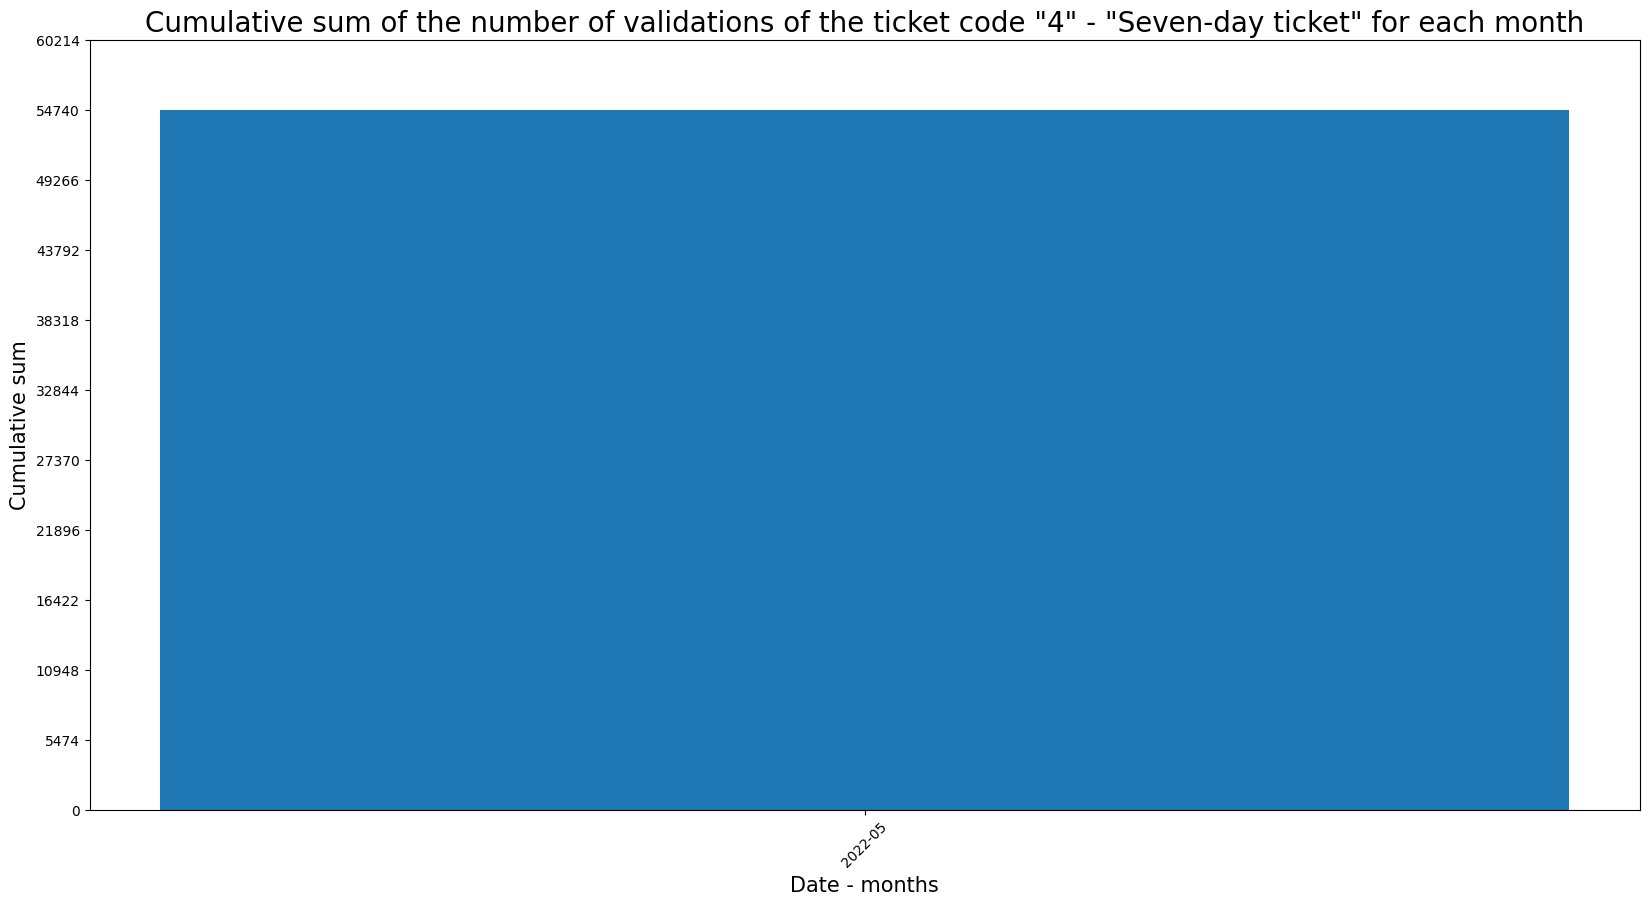

The highest number of validations of the ticket code "4" - "Seven-day ticket" was the month 2022-05 with 54745 validations.
The lowest number of validations of the ticket code "4" - "Seven-day ticket" was the month 2022-05 with 54745 validations.


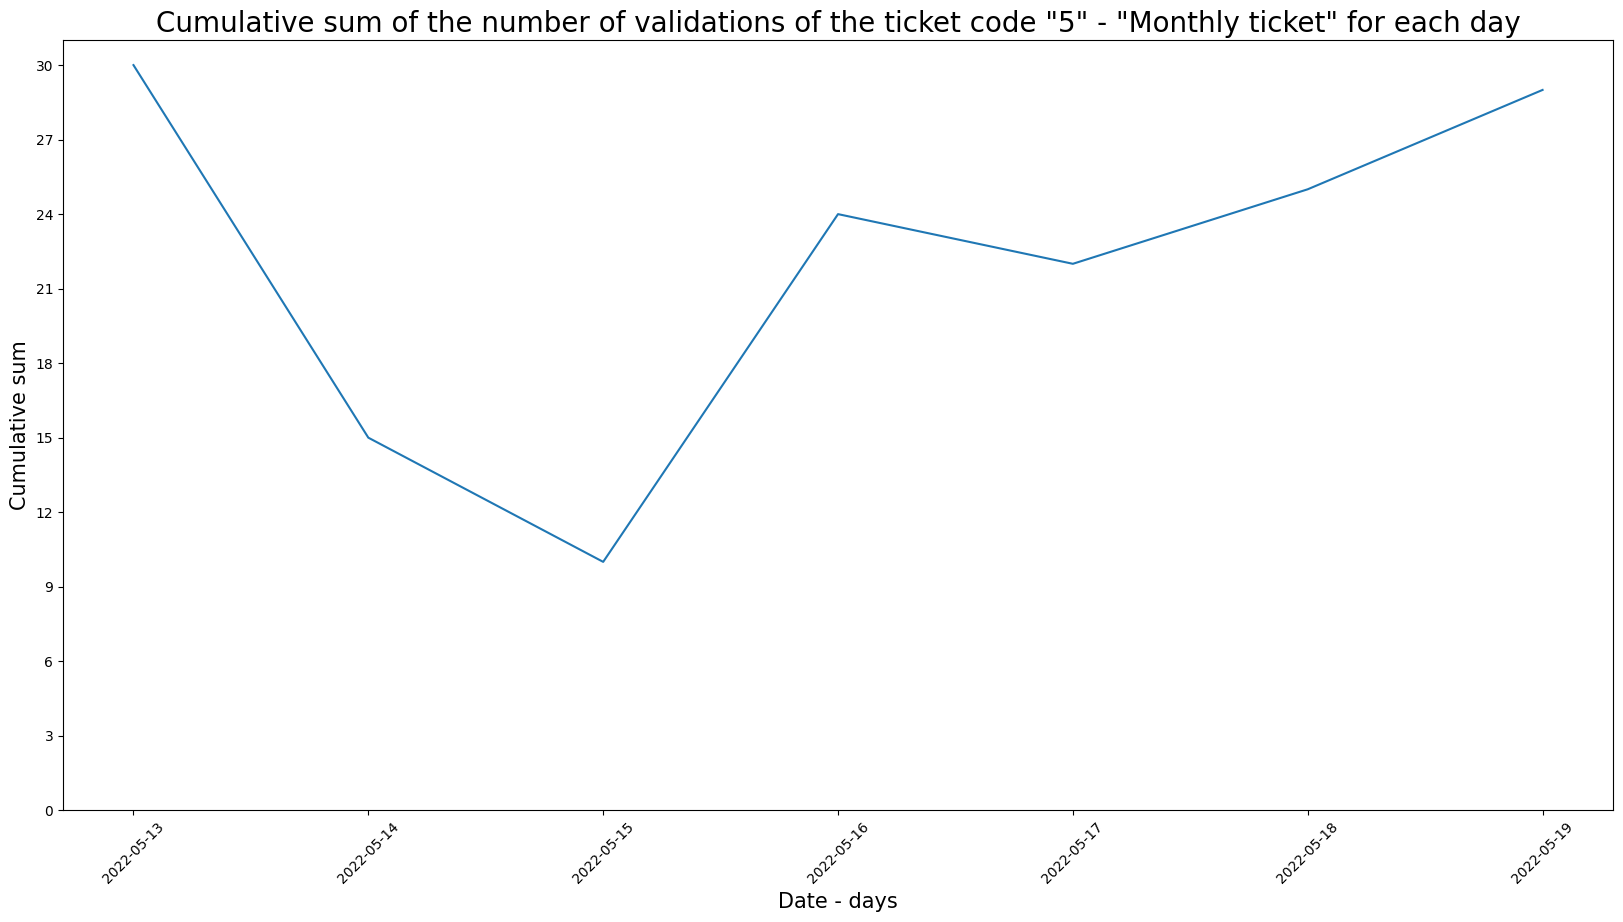

The highest number of validations of the ticket code "5" - "Monthly ticket" was 2022-05-13 with 30 validations
The lowest number of validations of the ticket code "5" - "Monthly ticket" was 2022-05-15 with 10 validations


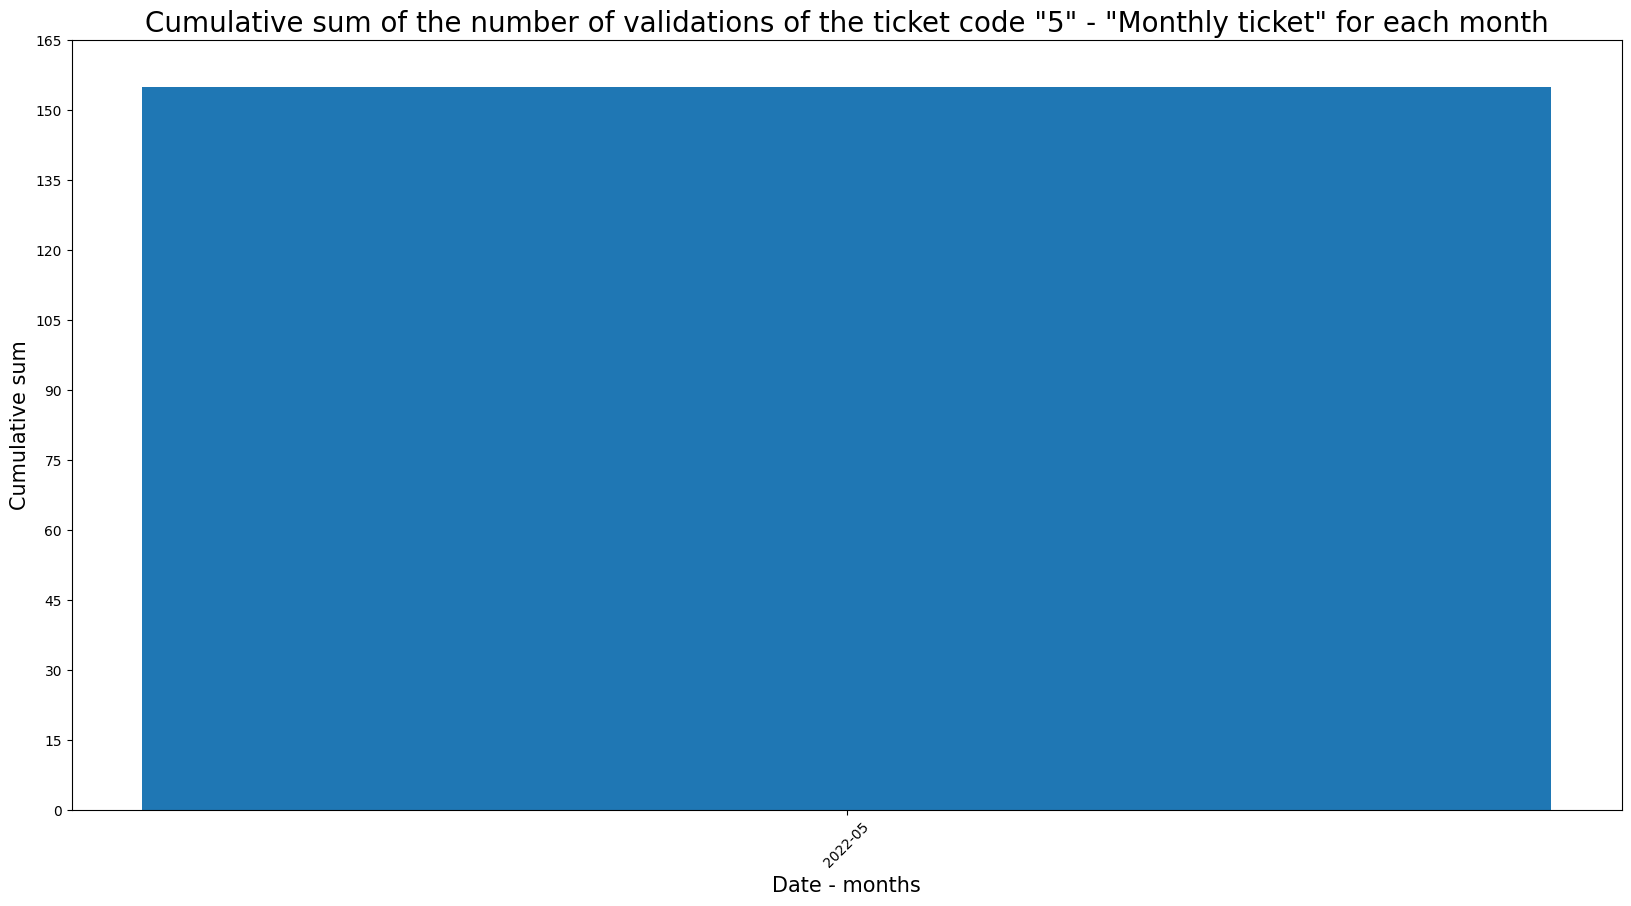

The highest number of validations of the ticket code "5" - "Monthly ticket" was the month 2022-05 with 155 validations.
The lowest number of validations of the ticket code "5" - "Monthly ticket" was the month 2022-05 with 155 validations.


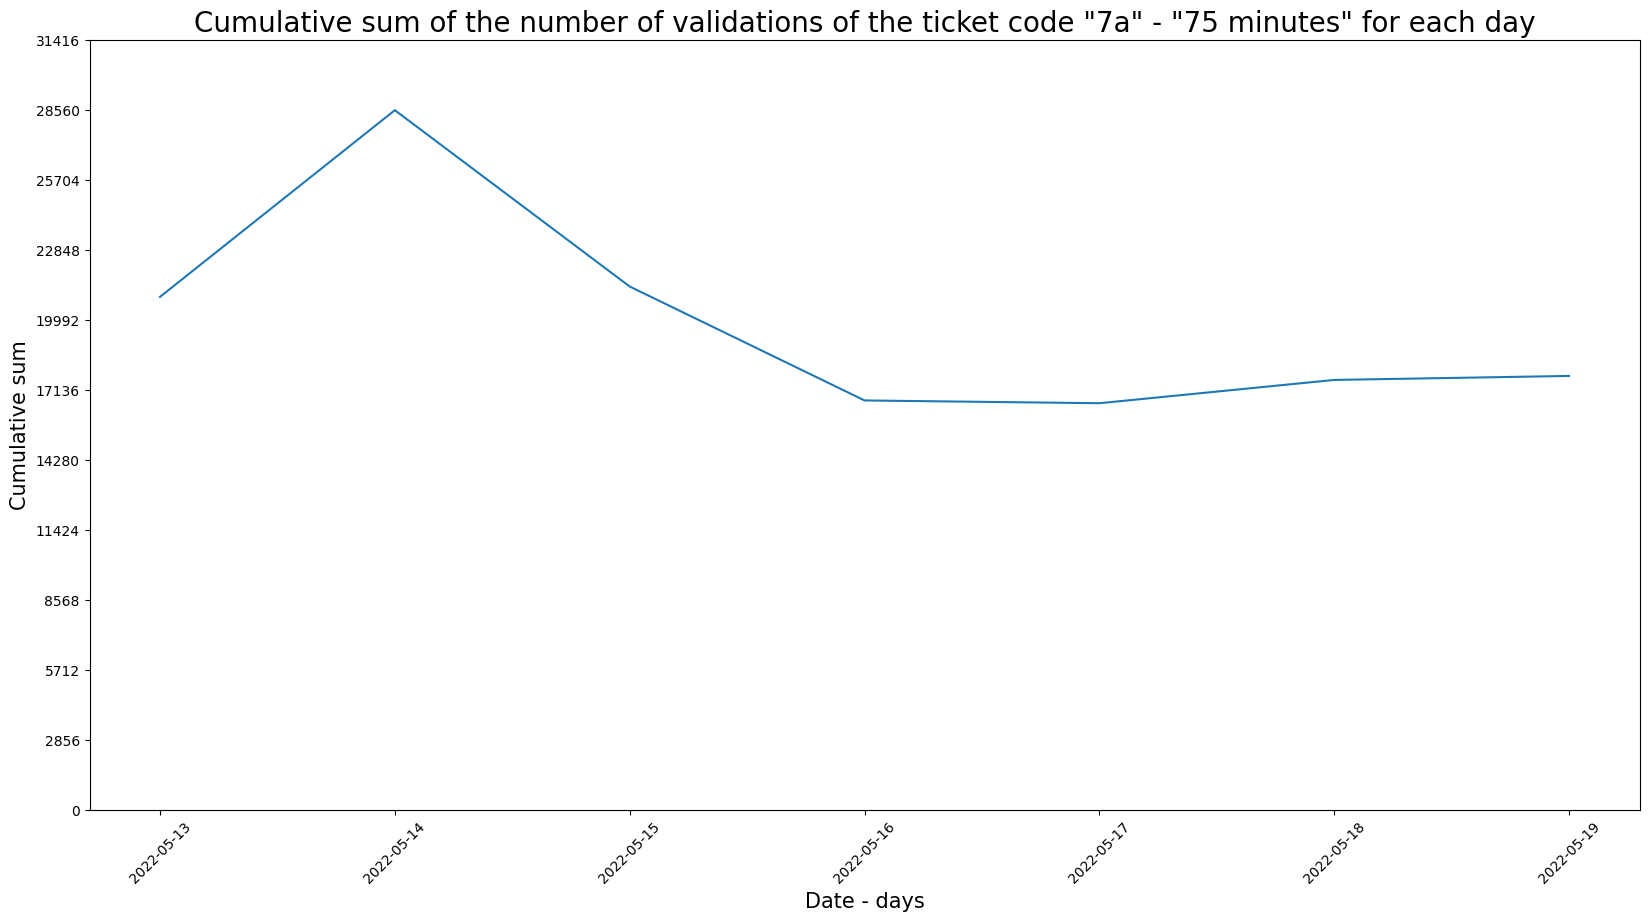

The highest number of validations of the ticket code "7a" - "75 minutes" was 2022-05-14 with 28563 validations
The lowest number of validations of the ticket code "7a" - "75 minutes" was 2022-05-17 with 16607 validations


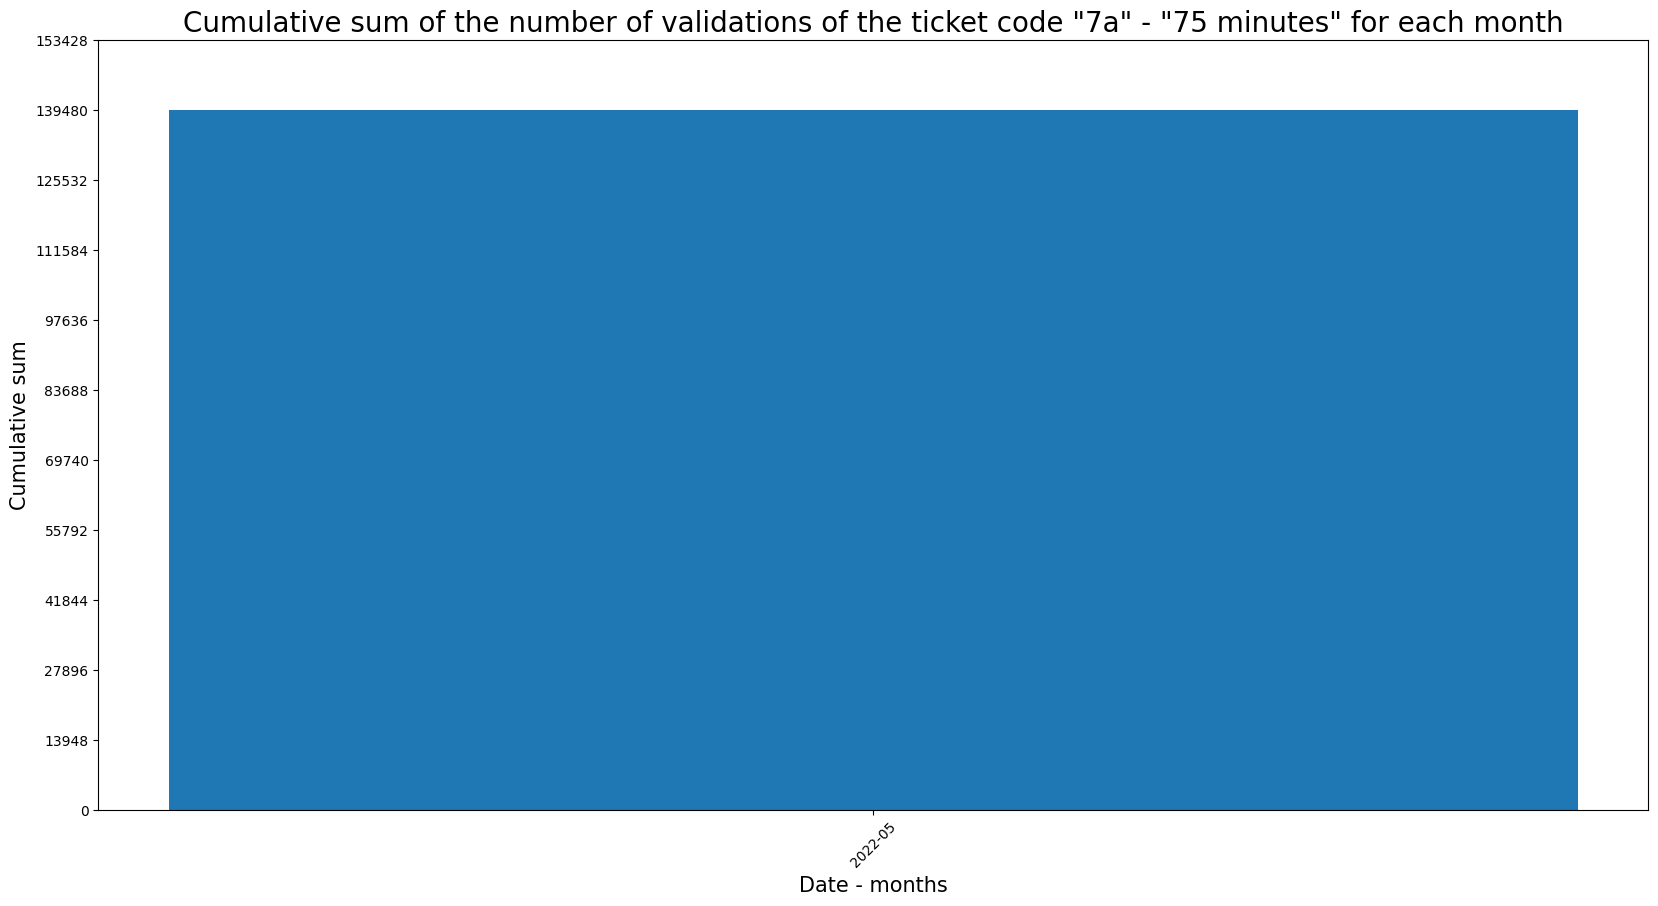

The highest number of validations of the ticket code "7a" - "75 minutes" was the month 2022-05 with 139481 validations.
The lowest number of validations of the ticket code "7a" - "75 minutes" was the month 2022-05 with 139481 validations.


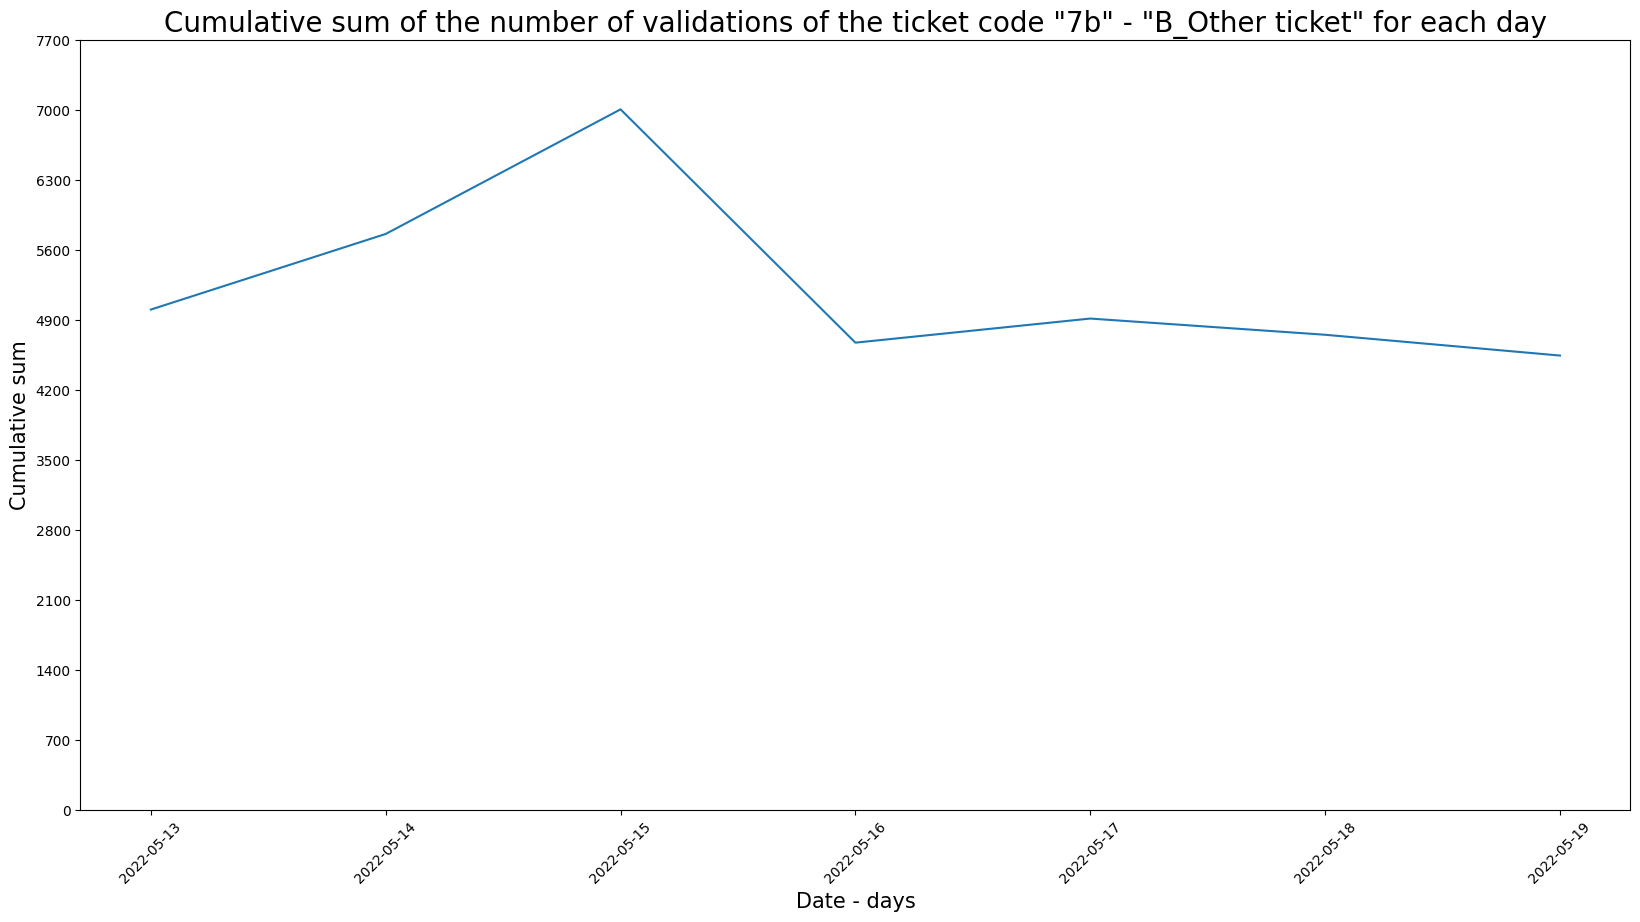

The highest number of validations of the ticket code "7b" - "B_Other ticket" was 2022-05-15 with 7009 validations
The lowest number of validations of the ticket code "7b" - "B_Other ticket" was 2022-05-19 with 4547 validations


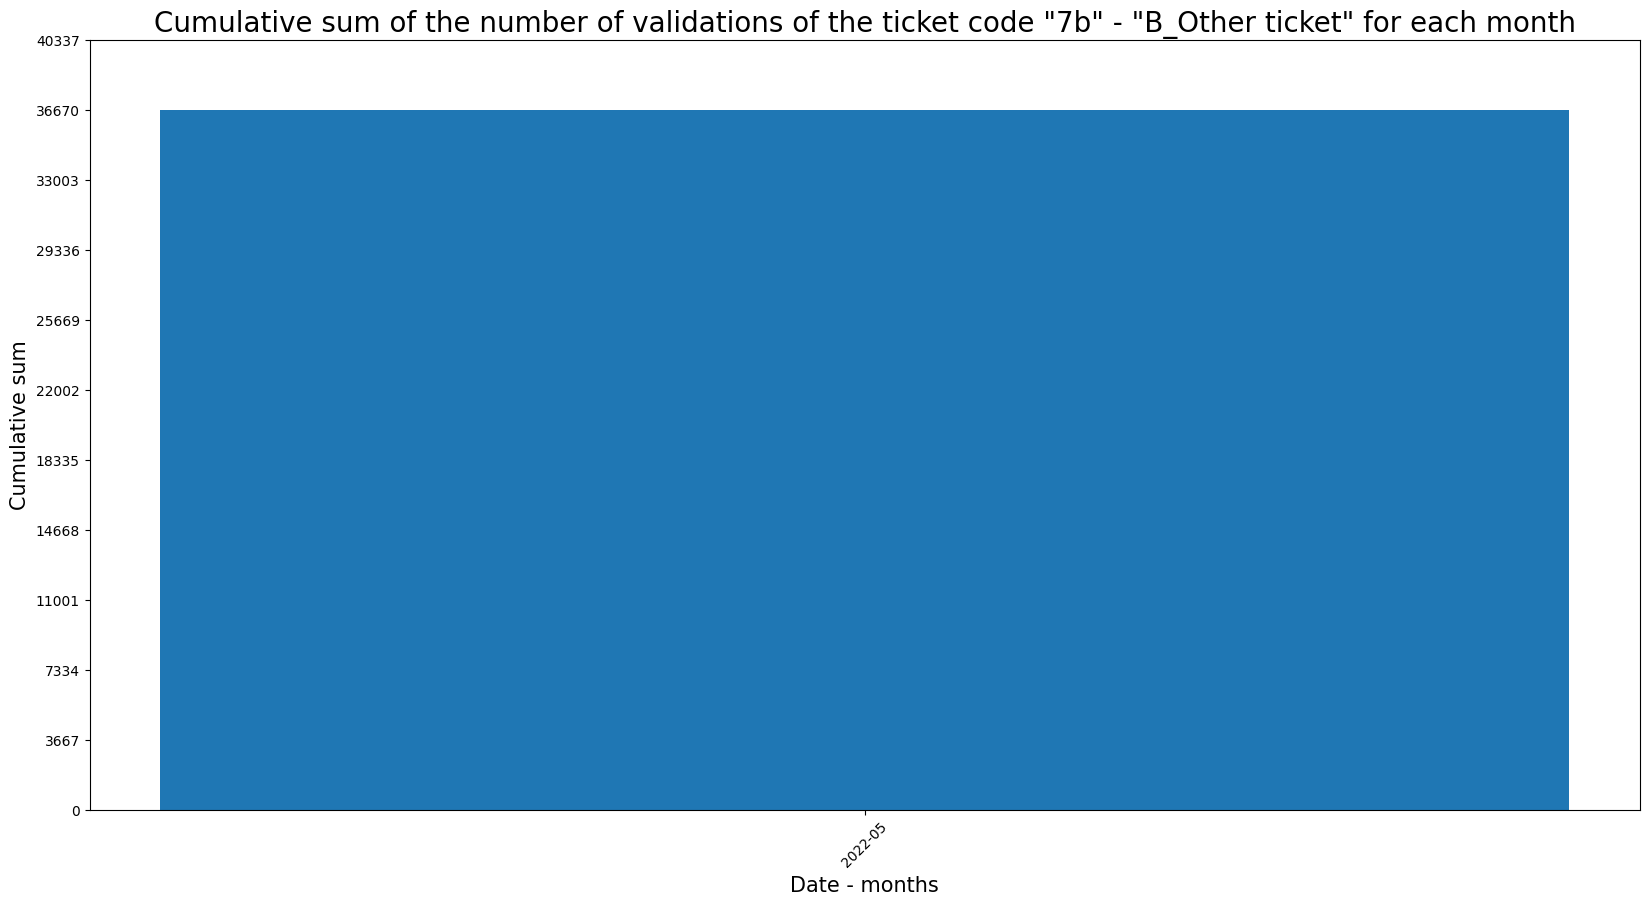

The highest number of validations of the ticket code "7b" - "B_Other ticket" was the month 2022-05 with 36674 validations.
The lowest number of validations of the ticket code "7b" - "B_Other ticket" was the month 2022-05 with 36674 validations.


In [55]:
# The TICKET_CODEs are in the dictionary "dict_ticket_codes.json", created in Notebook 1
focus_on_all_ticket_codes(df, 'data/dictionaries/dict_ticket_codes.json')

### Focus on the ticket code ***1***


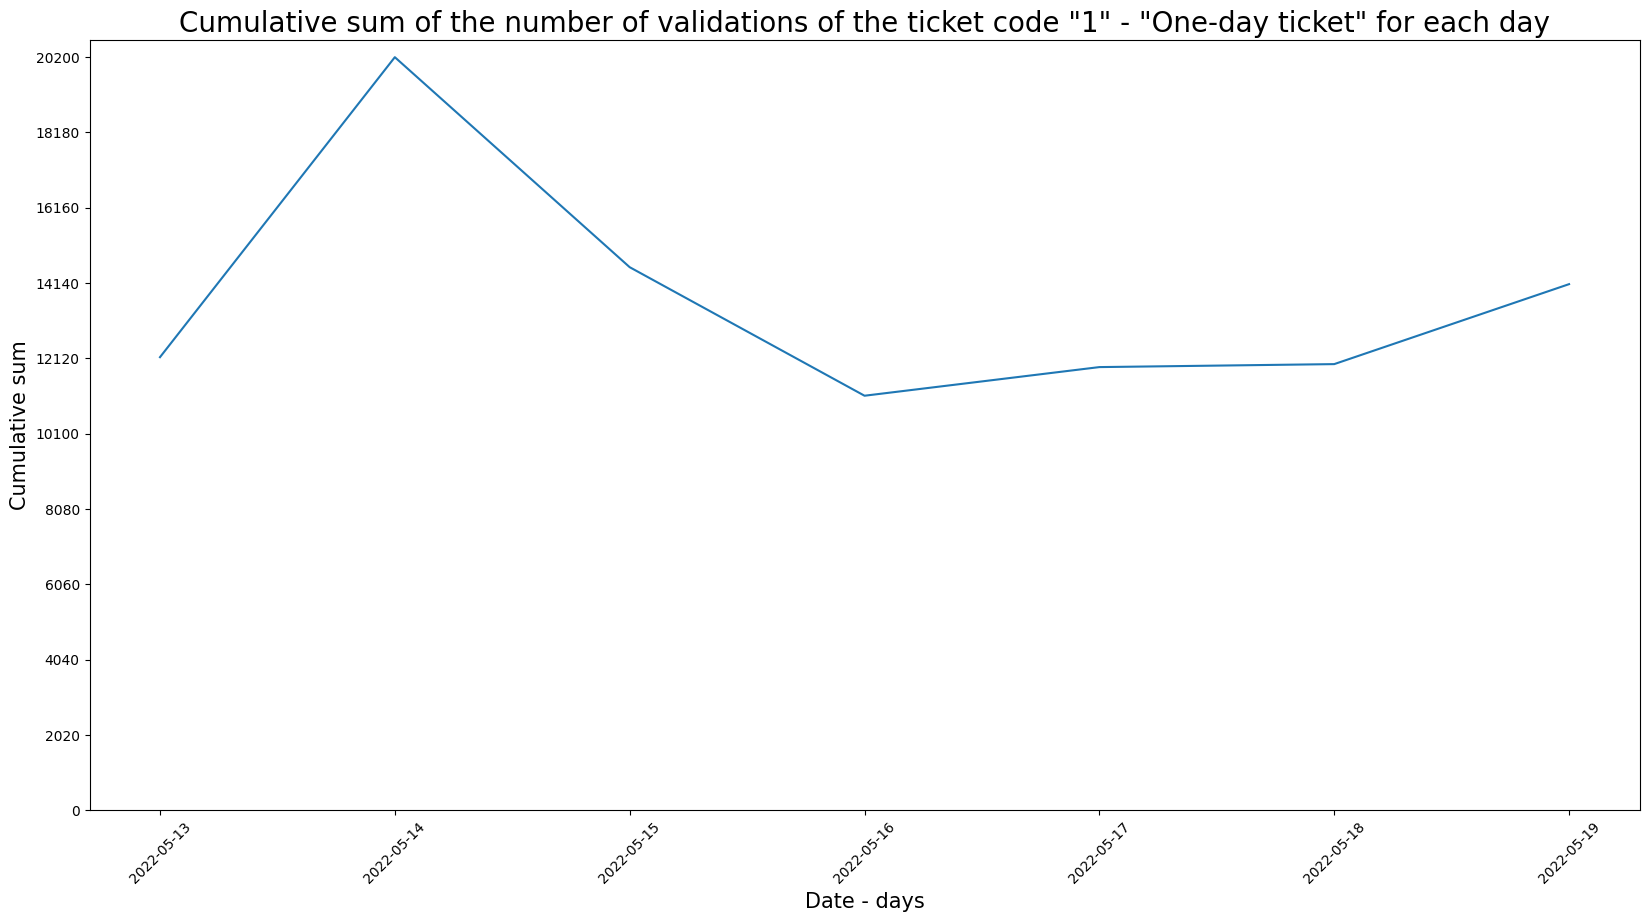

The highest number of validations of the ticket code "1" - "One-day ticket" was 2022-05-14 with 20200 validations
The lowest number of validations of the ticket code "1" - "One-day ticket" was 2022-05-16 with 11119 validations


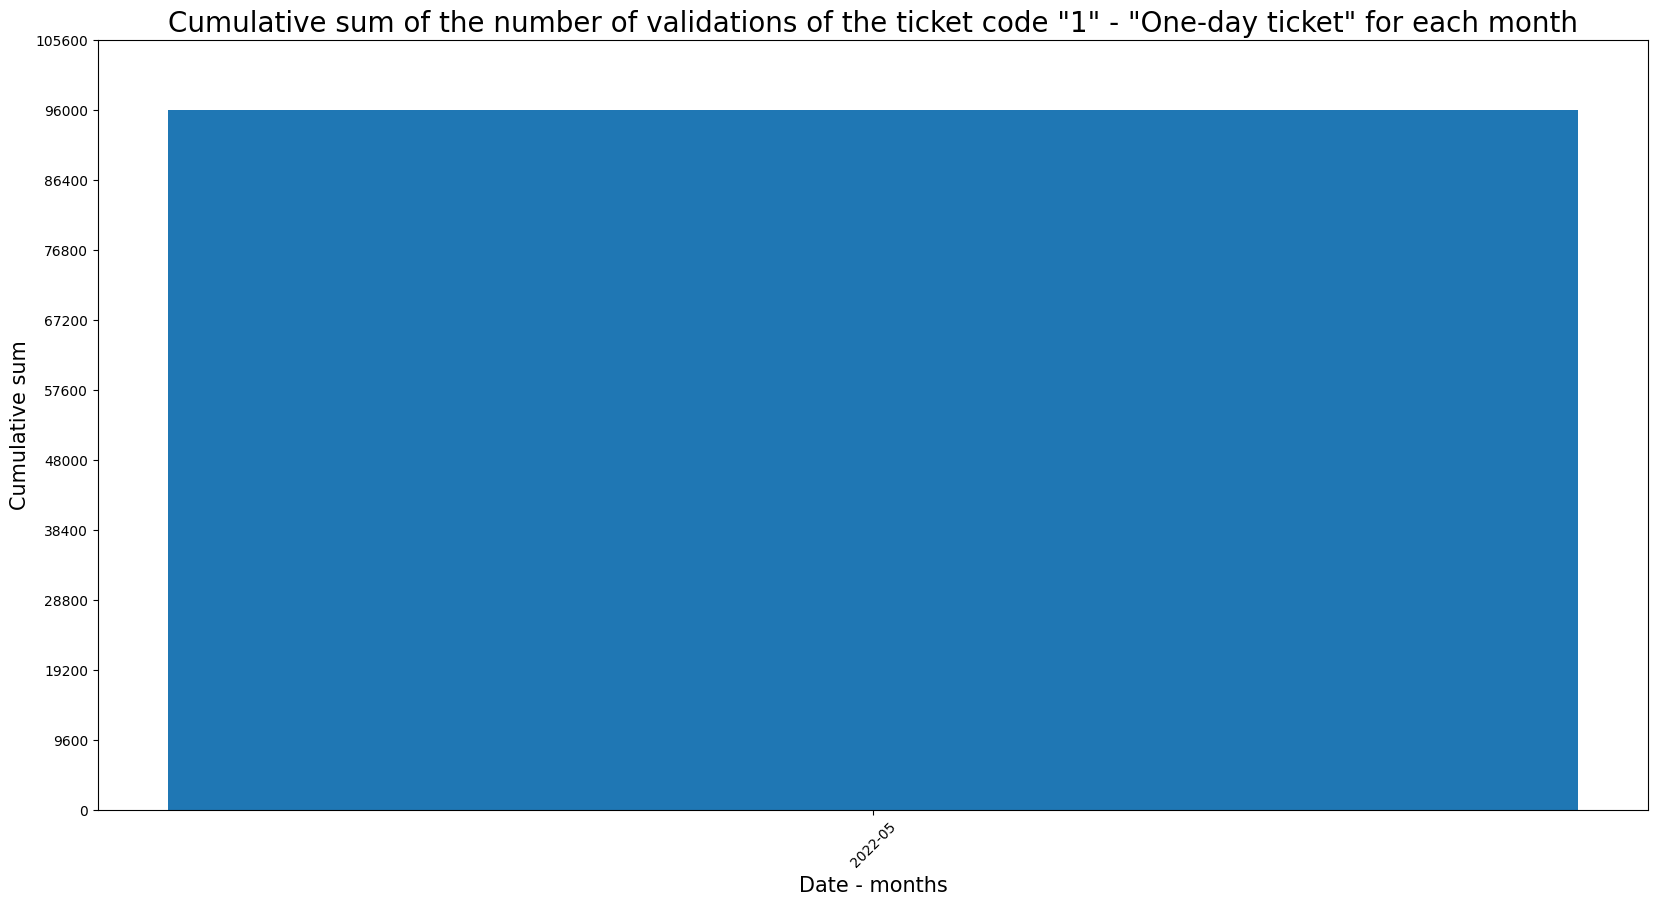

In [56]:
# Focus on TICKET_CODE = 1
target_ticket_code = '1'
df_tc1 = focus_on_ticket_code(df, target_ticket_code)
number_of_tickets_per_day(df_tc1, target_ticket_code, is_ticket_code=True)
min_max_number_of_tickets_per_day(df_tc1, target_ticket_code, is_ticket_code=True)
barplot_number_of_tickets_per_month(df_tc1, target_ticket_code, is_ticket_code=True)

------